In [2]:
# Standard library imports
import os
import time

# Third-party library imports
import cv2 as cv  # REMEMBER TO ADD THIS TO REQUIREMENTS!!!!!!
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models, Model
from keras.applications import VGG16
from keras.optimizers import Adam
from pydub import AudioSegment
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [4]:
def create_spectrogram(wav_path, sr=16000):

    y, sr = librosa.load(wav_path)

    # Create mel spectrogram
    mel_spect = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128,  # Number of mel bands
        fmax=8000,    # Maximum frequency
    )

    # Convert to log scale and return
    return np.array(librosa.power_to_db(mel_spect, ref=np.max))

wav_path = '../raw_data/0_30_2089_spirit_halloween.wav'
spectrogram = create_spectrogram(wav_path)
spectrogram.shape

(128, 216)

In [5]:
def resize_spectrogram(spectrogram, output_size):
    sp_row, sp_col = spectrogram.shape
    out_row, out_col = output_size
    resized_spec = zoom(spectrogram, (out_row/sp_row, out_col/sp_col))
    return resized_spec

In [6]:
def minmax_scaler(spectrogram):
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)

    normalised_spectrogram = (spectrogram - min_val) / (max_val - min_val)

    return normalised_spectrogram

In [7]:
def reshape_spectrogram(spectrogram):
    temp_spectogrram =  np.stack((spectrogram, spectrogram, spectrogram), axis=2)
    # final_spec = np.expand_dims(temp_spectogrram, axis=0)
    return temp_spectogrram

In [8]:
# Function to loop through all clip files and generate spectrograms
def get_features_model (folder_path):
    spectrograms = [] # This will store the spectrograms of each clip
    labels = []  # This will store the labels of each clip
    seconds = []  # Number of seconds to consider for each clip
    durations = []  # Duration of the full audio file
    podcast_names = []  # This will store the podcast names of each clip

    # Iterate over all files in the directory
    file_list = os.listdir(folder_path)
    print(f"Processing files: total {len(file_list)}")
    for filename in file_list:
        # Check if the file is a .wav or .mp3 (you can adjust this as needed)
        if filename.endswith('.wav') or filename.endswith('.mp3'):
            file_path = os.path.join(folder_path, filename)

            # Split the filename by underscore
            filename_parts = filename.split('_')

            # Extract 0 or 1 from the first part of the filename (label: ad or no_ad)
            is_ad = int(filename_parts[0])  # First part is the label

            # Extract the start time in seconds (second part of the filename)
            start_time = int(filename_parts[1])  # Second part is the start time in seconds

            # Extract the total duration (third part of the filename)
            duration = int(filename_parts[2])  # Third part is the total duration of the podcast

             # Extract the podcast name (four part of the filename)
            podcast_name = filename_parts[3].replace('.wav', '')  # Third part is the total duration of the podcast

            # Create spectrogram and convert to numpy array
            spectrogram = create_spectrogram(file_path)
            resized_spectrogram =resize_spectrogram(spectrogram, (224,224))
            scaled_spectrogram = minmax_scaler(resized_spectrogram)
            reshaped_spectrogram = reshape_spectrogram(scaled_spectrogram)

            # Append the numpy array to the list
            spectrograms.append(reshaped_spectrogram)
            labels.append(is_ad)
            seconds.append(start_time)
            durations.append(duration)
            podcast_names.append(podcast_name)

    return spectrograms, labels, seconds, durations, podcast_names

In [9]:
# Data folder path: Change this to the path where your audio clips are stored
folder_path = '../raw_data/OffMenu263'
all_spectrograms = get_features_model(folder_path)

Processing files: total 4800


In [37]:
X = np.array(all_spectrograms[0])
y = np.array(all_spectrograms[1])

print(np.array(X).shape)
print(np.array(y).shape)

(200, 224, 224, 3)
(200,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 224, 224, 3)
(40, 224, 224, 3)
(160,)
(40,)


VGG16
(96,64) optimal shape

base_model = 
include_top=False (you don't want top tlayers)
model = models,Sequential() *add this layer sigmoid activation at end

X = np.random.rand(samplenum, 96, 64, 1)

(128, 216)

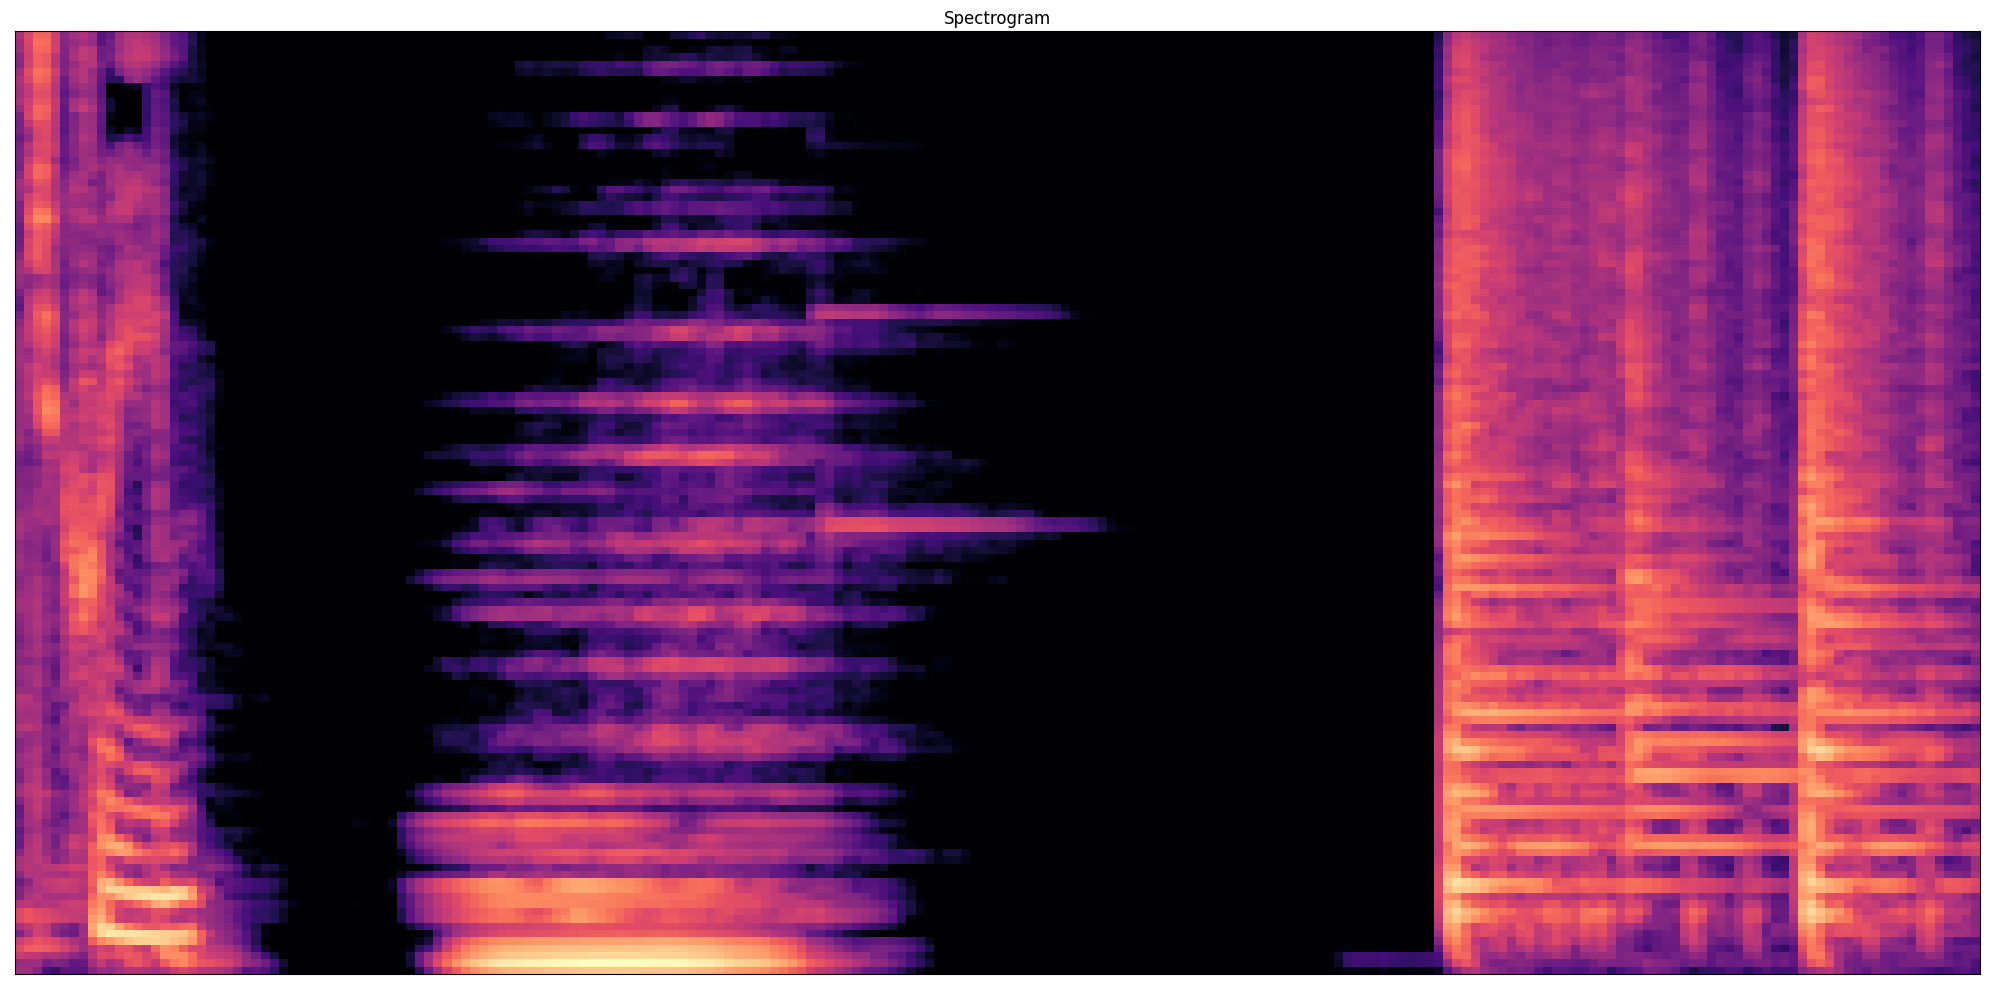

In [39]:
def plot_spectrogram(spectrogram_db, sr, hop_length):
    plt.figure(figsize=(20, 10))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length)
    plt.title('Spectrogram')
    plt.tight_layout()
    # plt.savefig(output_path)
    # plt.close()
plot_spectrogram(spectrogram, 16000, 1)
spectrogram.shape

# VGG-16 Model
# Import VGG16 and set the necessary arguments:

Freeze convolutional blocks

In [23]:
# for layer in base_model.layers:
#     layer.trainable = False
# # Make sure you have frozen the correct layers
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name, layer.trainable)

In [24]:
# (X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [40]:

def build_baseline_model(input_shape=(224, 224, 3), freeze_base=True):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        input_shape=input_shape,
        weights=None)

    base_model.trainable = freeze_base  # base model is not trainable
    x = base_model.output

    # flatten
    x = layers.Flatten()(x)

    # dense layer for ad detection
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # output layer for ad detection
    output = layers.Dense(1, activation='sigmoid')(x)
    loss = 'binary_crossentropy'

    # create
    model = models.Model(
        inputs=base_model.input,
        outputs=output
    )

    # compile
    model.compile(
        loss=loss,
        optimizer='adam',  # try Adam(learning_rate=0.01)
        metrics=['accuracy']
    )

    return model

In [41]:
model = build_baseline_model(
    input_shape=(224, 224, 3),
    freeze_base=True
)


In [42]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10
10/10 [==============================] - 51s 5s/step - loss: 0.3657 - accuracy: 0.9375 - val_loss: 0.1111 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 87s 9s/step - loss: 0.0520 - accuracy: 1.0000 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 115s 12s/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 107s 11s/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 117s 12s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 94s 9s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 85s 9s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 8/10
10/

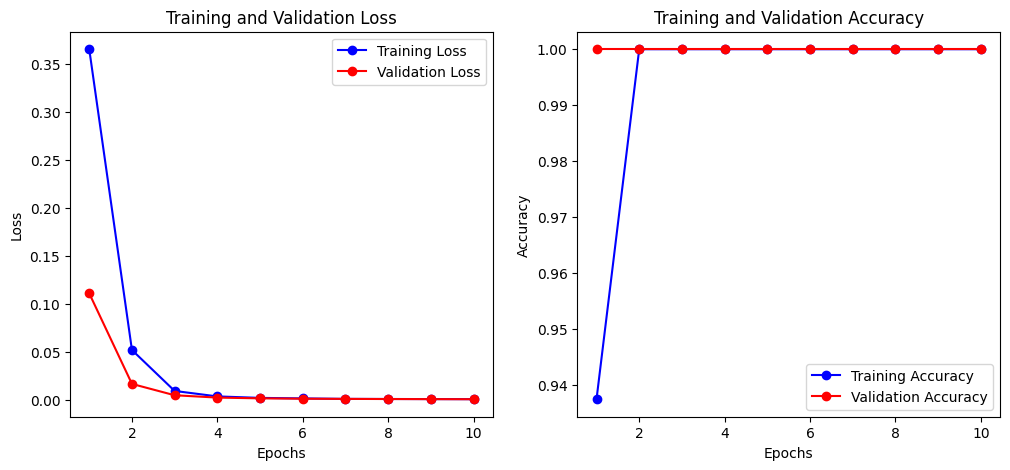

In [43]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)
